## Device check

In [1]:
!nvidia-smi

Tue Oct 31 09:58:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:B3:00.0 Off |                    0 |
| N/A   30C    P0    41W / 300W |      0MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Packages

In [2]:
import warnings
warnings.filterwarnings(action="ignore")

In [73]:

import lightning.pytorch as pl
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.callbacks import RichProgressBar, TQDMProgressBar
from lightning.pytorch.callbacks.progress.rich_progress import RichProgressBarTheme
from lightning.pytorch.loggers import TensorBoardLogger

import logging
logging.basicConfig(level="INFO")

import math
from matplotlib import pyplot
%matplotlib inline

import numpy as np

import os

import pandas as pd
from pprint import pprint

import sys
sys.path.append("../src")

import timm
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
from typing import Tuple


In [4]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
%load_ext autoreload
%autoreload 2

In [6]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [8]:
import config
from dataloader import BEDataset, BEDataModule
import token_learner
from transformer import PositionalEncoder, SelfAttentionHead, MultiHeadSelfAttention, FeedFowardLayer, LayerNormalization, TransformerDecoderLayer, TransformerDecoder, generate_causal_attention_mask

from film_layers import FiLMBlockV2, FiLMEncoder, ResBlockDWConv
from rt1 import RT1Encoder, RT1Decoder, ActionGenerator
from utils.data_utils import History
from utils.model_utils import TextEncoder, ImageFeatureExtractor, plot_attention


## Data Module

In [9]:
dm = BEDataModule()
dm.setup()

INFO:root:Training on 3586 samples.
INFO:root:Validating on 922 samples.
INFO:root:Testing on 250 samples.


Total # examples: 4758


## Fetch batch

In [36]:
# sample = next(iter(dm.test_dataloader()))
# print(sample.keys())
# sample["in_state"].shape

In [13]:
%%time
sample = next(iter(dm.train_dataloader()))
print(sample.keys())
sample["in_state"].shape

dict_keys(['sample_id', 'in_state', 'action_desc', 'source_mask_tokens', 'source_mask', 'motor_cmd', 'target_mask'])
CPU times: user 18.2 ms, sys: 161 ms, total: 179 ms
Wall time: 1.4 s


torch.Size([8, 3, 288, 288])

In [14]:
sample["source_mask"].shape

torch.Size([8, 1, 1, 16])

In [15]:
sample["source_mask_tokens"].shape

torch.Size([8, 1, 1, 48])

In [ ]:
# sample["source_mask"].shape, sample["target_mask"].shape

In [ ]:
# sample["motor_cmd"]["labels"]

## Model Design

<!-- ![RT1 model architecture](../../imgs/rt1+.png) -->
<center>
    <img src="../imgs/rt1+.png" alt="RT1 model architecture" width="300" height="400">

<center>

### Encoder

#### Test Text Encoder

In [16]:
# te = TextEncoder(freeze=True).cuda()
# summary(model=te, col_names=["num_params", "trainable"])

In [ ]:
# emb, inp_seq_enc = te(
#     inp_ids=sample["action_desc"]["ids"].cuda(),
#     mask=sample["action_desc"]["mask"].cuda(),
#     tok_type_ids=sample["action_desc"]["token_type_ids"].cuda()
# )

# emb.shape, inp_seq_enc.shape

#### Test Img Feature Extractor

In [ ]:
# fe = ImageFeatureExtractor(pretrained=True, arch="efficientnet_b3").cuda()

# summary(fe, col_names=["num_params", "trainable"])

In [ ]:
# img_ftrs = fe(sample["in_state"].cuda())

# img_ftrs.shape

#### Test FiLM Block

In [16]:
# film_block = FiLMBlockV2().cuda()
# print(film_block)
# summary(model=film_block)

In [17]:
# text_cond_ftrs = film_block(
#     img_features=img_ftrs, 
#     conditioning=emb
# )

# text_cond_ftrs.shape

#### Test Residual FiLM Block

In [18]:
# dw_res = ResBlockDWConv(512, 512).cuda()
# summary(model=dw_res)

In [19]:
# text_cond_ftrs_res = dw_res(
#     img_features=img_ftrs, 
#     conditioning=emb
# )

# text_cond_ftrs_res.shape

#### Test FiLM Encoder

In [20]:
# film_encoder = FiLMEncoder(
#     arch="resnet34",
#     n_res_blocks=6,
# ).cuda()

# # print(film_encoder)
# summary(model=film_encoder)

In [21]:
# %%time

# out = film_encoder(
#     x= sample["in_state"].cuda(),
#     conditioning= emb
# )

# out.shape

#### Token Learner

In [22]:
# N, C, H_W = out.shape
# N, C, H_W

In [23]:
# tokL_v11 = token_learner.TokenLearnerModuleV11(feature_shape=(N, H_W, C)).cuda()
# print(tokL_v11)
# summary(model=tokL_v11)

In [24]:
# learned_tokens = tokL_v11(out.view(N, H_W, C))
# learned_tokens.shape

In [154]:
tokenized_inputs = torch.empty((B, config.NUM_HISTORY+1, config.D_MODEL, config.NUM_LEARNED_TOKENS))
tokenized_inputs.shape

torch.Size([8, 6, 512, 8])

#### RT-1 Encoder

In [19]:
encoder = RT1Encoder(
    cnn_bacnbone="efficientnet_b3", 
    num_res_blocks=6, 
    freeze_cnn_backbone=True
).to(config.DEVICE)

summary(model=encoder, col_names=["num_params", "trainable"])

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/efficientnet_b3.ra2_in1k)
INFO:timm.models._hub:[timm/efficientnet_b3.ra2_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


Layer (type:depth-idx)                                       Param #                   Trainable
RT1Encoder                                                   --                        Partial
├─TextEncoder: 1-1                                           --                        False
│    └─BertModel: 2-1                                        --                        False
│    │    └─BertEmbeddings: 3-1                              (15,891,456)              False
│    │    └─BertEncoder: 3-2                                 (12,609,536)              False
│    │    └─BertPooler: 3-3                                  (262,656)                 False
│    └─Dropout: 2-2                                          --                        --
├─FiLMEncoder: 1-2                                           --                        Partial
│    └─ImageFeatureExtractor: 2-3                            --                        Partial
│    │    └─EfficientNetFeatures: 3-4                        (1

In [20]:
%%time

text_enc_h_state, learned_tokens = encoder(
    input_ids=sample["action_desc"]["ids"].cuda(),
    attn_mask=sample["action_desc"]["mask"].cuda(),
    token_type_ids=sample["action_desc"]["token_type_ids"].cuda(),
    imgs=sample["in_state"].cuda()
)

learned_tokens.shape, learned_tokens.device, text_enc_h_state.shape

CPU times: user 1.26 s, sys: 1.06 s, total: 2.32 s
Wall time: 12.3 s


(torch.Size([8, 48, 512]),
 device(type='cuda', index=0),
 torch.Size([8, 16, 512]))

### Decoder

In [21]:
inp_embedding = encoder.text_encoder.encoder.embeddings

target_embedding = nn.Embedding(
    num_embeddings=config.TARGET_VOCAB_SIZE, 
    embedding_dim=config.EMBEDDING_DIM, 
    padding_idx=config.TGT_PAD_TOK_ID
).cuda()

In [22]:
inp = sample["action_desc"]["ids"].cuda()
outp = sample["motor_cmd"]["decoder_inp_ids"].cuda()

inp_emb = inp_embedding(inp)
outp_emb = target_embedding(outp)

inp_emb.shape, outp_emb.shape

(torch.Size([8, 16, 512]), torch.Size([8, 16, 512]))

#### Test MultiHead Self-Attention Layer

In [248]:
# sa = SelfAttentionHead().cuda()
# sa.eval()
# print(sa)
# summary(sa)

In [298]:
# %%time

# mem, attn_w = sa(
#     q=inp_emb, 
#     k=inp_emb, 
#     v=inp_emb, 
#     mask=sample["target_mask"].cuda(),
#     return_weights=True
# )

# mem.shape, attn_w.shape

CPU times: user 2.38 ms, sys: 5 ms, total: 7.38 ms
Wall time: 209 ms


(torch.Size([4, 16, 512]), torch.Size([4, 16, 16]))

In [250]:
# plot_attention(attn_w)

In [251]:
mhsa = MultiHeadSelfAttention(num_heads=4).cuda()
mhsa.eval()
print(mhsa)
summary(mhsa)

MultiHeadSelfAttention(
  (attention_heads): ModuleList(
    (0-3): 4 x SelfAttentionHead(
      (dropout): Dropout(p=0.1, inplace=False)
      (_softmax): Softmax(dim=-1)
      (w_q): Linear(in_features=512, out_features=512, bias=False)
      (w_k): Linear(in_features=512, out_features=512, bias=False)
      (w_v): Linear(in_features=512, out_features=512, bias=False)
    )
  )
  (output_layer): Sequential(
    (0): Linear(in_features=2048, out_features=512, bias=False)
    (1): Dropout(p=0.1, inplace=False)
  )
)


Layer (type:depth-idx)                   Param #
MultiHeadSelfAttention                   --
├─ModuleList: 1-1                        --
│    └─SelfAttentionHead: 2-1            --
│    │    └─Dropout: 3-1                 --
│    │    └─Softmax: 3-2                 --
│    │    └─Linear: 3-3                  262,144
│    │    └─Linear: 3-4                  262,144
│    │    └─Linear: 3-5                  262,144
│    └─SelfAttentionHead: 2-2            --
│    │    └─Dropout: 3-6                 --
│    │    └─Softmax: 3-7                 --
│    │    └─Linear: 3-8                  262,144
│    │    └─Linear: 3-9                  262,144
│    │    └─Linear: 3-10                 262,144
│    └─SelfAttentionHead: 2-3            --
│    │    └─Dropout: 3-11                --
│    │    └─Softmax: 3-12                --
│    │    └─Linear: 3-13                 262,144
│    │    └─Linear: 3-14                 262,144
│    │    └─Linear: 3-15                 262,144
│    └─SelfAttentionHead: 

In [279]:
%%time

mem, attn_w = mhsa(
    q=inp_emb, 
    k=inp_emb, 
    v=inp_emb, 
    mask=sample["target_mask"].cuda(),
    return_weights=True
)

mem.shape, attn_w.shape

CPU times: user 2.73 ms, sys: 79 µs, total: 2.81 ms
Wall time: 2.28 ms


(torch.Size([4, 16, 512]), torch.Size([4, 4, 16, 16]))

In [280]:
attn_w[0, 0, 0]

tensor([0.0606, 0.0543, 0.0559, 0.0649, 0.0481, 0.0547, 0.0406, 0.0551, 0.0659,
        0.0666, 0.0759, 0.0744, 0.0740, 0.0715, 0.0697, 0.0679],
       device='cuda:0', grad_fn=<SelectBackward0>)

#### Plot Self-attention weights

In [16]:
# plot_attention(attn_w)
# plot_attention(attn_w, example_idx=2)

#### Test Cross Attention Layer

In [282]:
# num_heads = 2

# cross_attention = MultiHeadSelfAttention(
#     num_heads=num_heads
# ).cuda()

# cross_attention.eval()
# print(cross_attention)
# summary(cross_attention)

MultiHeadSelfAttention(
  (attention_heads): ModuleList(
    (0-1): 2 x SelfAttentionHead(
      (dropout): Dropout(p=0.1, inplace=False)
      (_softmax): Softmax(dim=-1)
      (w_q): Linear(in_features=512, out_features=512, bias=False)
      (w_k): Linear(in_features=512, out_features=512, bias=False)
      (w_v): Linear(in_features=512, out_features=512, bias=False)
    )
  )
  (output_layer): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=False)
    (1): Dropout(p=0.1, inplace=False)
  )
)


Layer (type:depth-idx)                   Param #
MultiHeadSelfAttention                   --
├─ModuleList: 1-1                        --
│    └─SelfAttentionHead: 2-1            --
│    │    └─Dropout: 3-1                 --
│    │    └─Softmax: 3-2                 --
│    │    └─Linear: 3-3                  262,144
│    │    └─Linear: 3-4                  262,144
│    │    └─Linear: 3-5                  262,144
│    └─SelfAttentionHead: 2-2            --
│    │    └─Dropout: 3-6                 --
│    │    └─Softmax: 3-7                 --
│    │    └─Linear: 3-8                  262,144
│    │    └─Linear: 3-9                  262,144
│    │    └─Linear: 3-10                 262,144
├─Sequential: 1-2                        --
│    └─Linear: 2-3                       524,288
│    └─Dropout: 2-4                      --
Total params: 2,097,152
Trainable params: 2,097,152
Non-trainable params: 0

In [283]:
%%time

cross_attn_mem, cross_attn_w = cross_attention(
    q=inp_emb, 
    k=learned_tokens, 
    v=learned_tokens, 
    mask=sample["source_mask"].cuda(),
    return_weights=True
)

cross_attn_mem.shape, cross_attn_w.shape

CPU times: user 793 µs, sys: 864 µs, total: 1.66 ms
Wall time: 1.33 ms


(torch.Size([4, 16, 512]), torch.Size([4, 2, 16, 48]))

#### Plot Cross attention weights

In [17]:
# plot_attention(cross_attn_w)
# plot_attention(cross_attn_w, example_idx=2)

#### Test Transformer decoder layer

In [18]:
# dec_layer = TransformerDecoderLayer().cuda()
# print(dec_layer)
# dec_layer.eval()
# summary(dec_layer)

In [20]:
# dec_out, self_attn_w, cross_attn_w = dec_layer(
#     inp=inp_emb, 
#     encoder_out=learned_tokens, 
#     src_mask=sample["source_mask"].cuda(), 
#     target_mask=sample["target_mask"].cuda(), 
#     debug=False
# )
# dec_out.shape, self_attn_w.shape, cross_attn_w.shape

In [19]:
# plot_attention(self_attn_w)
# plot_attention(cross_attn_w)

#### Test Transformer decoder

In [23]:
dec = TransformerDecoder(num_layers=1).cuda()
print(dec)
dec.eval()
summary(model=dec)

TransformerDecoder(
  (token_emb): Linear(in_features=512, out_features=512, bias=False)
  (position_emb): Linear(in_features=16, out_features=512, bias=False)
  (layers): ModuleList(
    (0): TransformerDecoderLayer(
      (self_attn): MultiHeadSelfAttention(
        (attention_heads): ModuleList(
          (0-7): 8 x SelfAttentionHead(
            (dropout): Dropout(p=0.2, inplace=False)
            (_softmax): Softmax(dim=-1)
            (w_q): Linear(in_features=512, out_features=512, bias=False)
            (w_k): Linear(in_features=512, out_features=512, bias=False)
            (w_v): Linear(in_features=512, out_features=512, bias=False)
          )
        )
        (output_layer): Sequential(
          (0): Linear(in_features=4096, out_features=512, bias=False)
          (1): Dropout(p=0.2, inplace=False)
        )
      )
      (cross_attn): MultiHeadSelfAttention(
        (attention_heads): ModuleList(
          (0-7): 8 x SelfAttentionHead(
            (dropout): Dropout(p=0

Layer (type:depth-idx)                             Param #
TransformerDecoder                                 --
├─Linear: 1-1                                      262,144
├─Linear: 1-2                                      8,192
├─ModuleList: 1-3                                  --
│    └─TransformerDecoderLayer: 2-1                --
│    │    └─MultiHeadSelfAttention: 3-1            8,388,608
│    │    └─MultiHeadSelfAttention: 3-2            8,388,608
│    │    └─LayerNormalization: 3-3                1,024
│    │    └─LayerNormalization: 3-4                1,024
│    │    └─Sequential: 3-5                        2,099,712
│    │    └─LayerNorm: 3-6                         1,024
│    │    └─Dropout: 3-7                           --
Total params: 19,150,336
Trainable params: 19,150,336
Non-trainable params: 0

#### With (Seq) positional encooding

In [46]:
# pos_embedding = PositionalEncoder(seq_len=config.MAX_LEN).cuda()

In [47]:
# outp_emb_ = pos_embedding(outp_emb)

In [48]:
# dec_out, self_attn_ws, cross_attn_ws = dec(
#     inp=outp_emb_, 
#     encoder_out=learned_tokens, 
#     src_mask=sample["source_mask"].cuda(), 
#     target_mask=sample["target_mask"].cuda(), 
#     debug=False
# )

# dec_out.shape, self_attn_ws.shape, cross_attn_ws.shape

(torch.Size([8, 16, 512]),
 torch.Size([8, 8, 16, 16]),
 torch.Size([8, 8, 16, 48]))

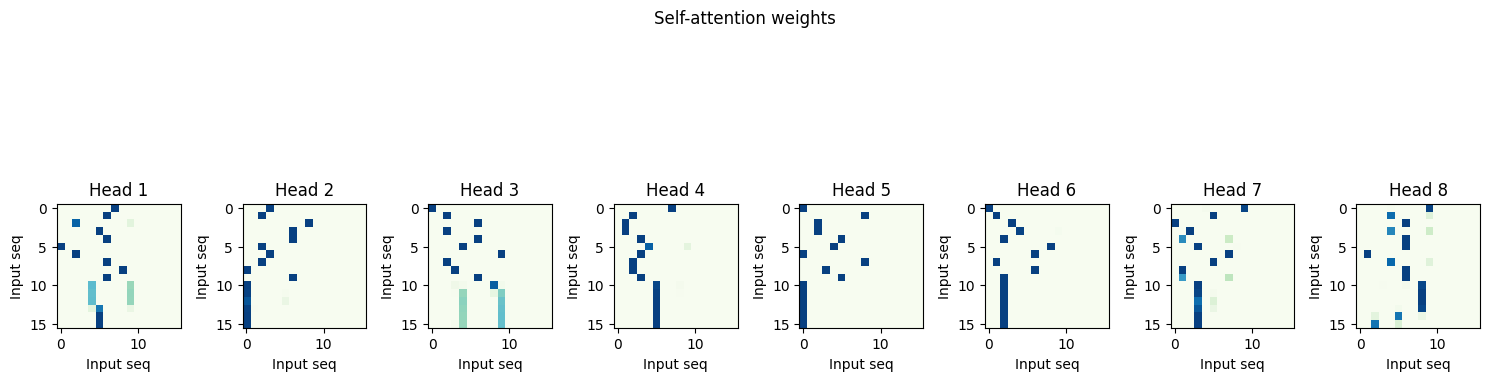

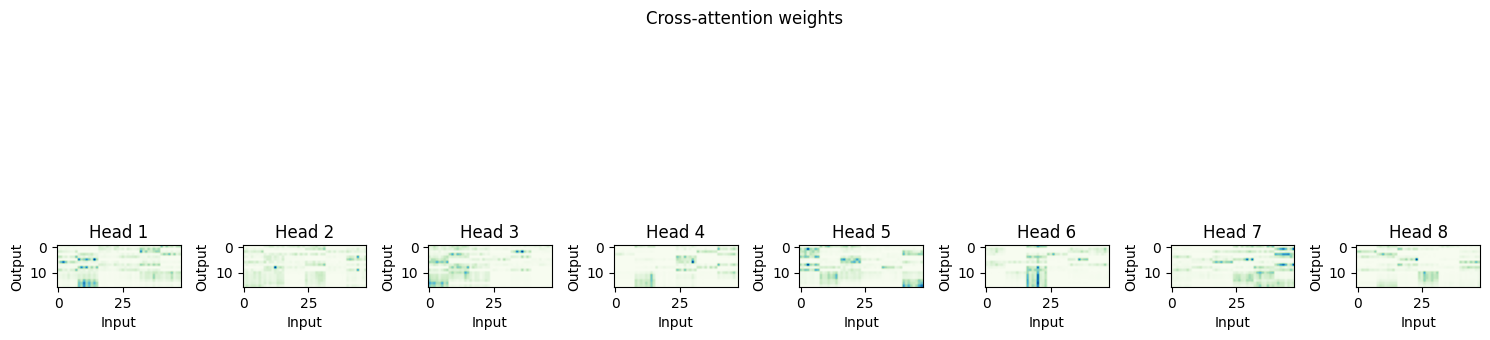

In [49]:
# plot_attention(self_attn_ws)
# plot_attention(cross_attn_ws)

#### With Linear positional encooding (similar to tf RT1)

In [24]:
outp_emb.shape

torch.Size([8, 16, 512])

In [26]:
dec_out, self_attn_ws, cross_attn_ws_seq, cross_attn_ws_tokens = dec(
    inp=outp_emb, 
    encoder_outs=(text_enc_h_state, learned_tokens), 
    src_mask=(sample["source_mask"].cuda(), sample["source_mask_tokens"].cuda()), 
    target_mask=sample["target_mask"].cuda(), 
    debug=False
)

dec_out.shape, self_attn_ws.shape, cross_attn_ws_seq.shape, cross_attn_ws_tokens.shape

(torch.Size([8, 16, 512]),
 torch.Size([8, 8, 16, 16]),
 torch.Size([8, 8, 16, 16]),
 torch.Size([8, 8, 16, 48]))

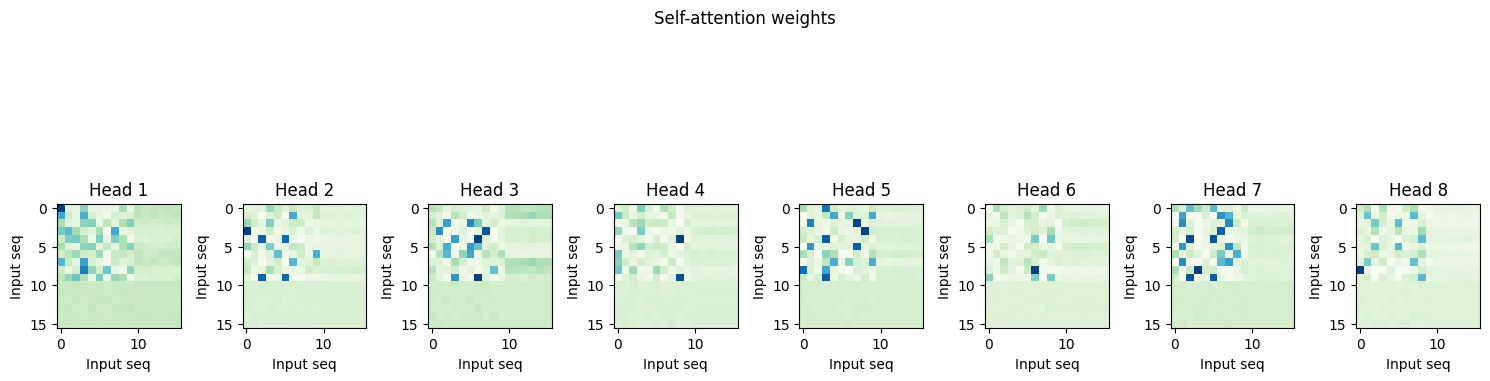

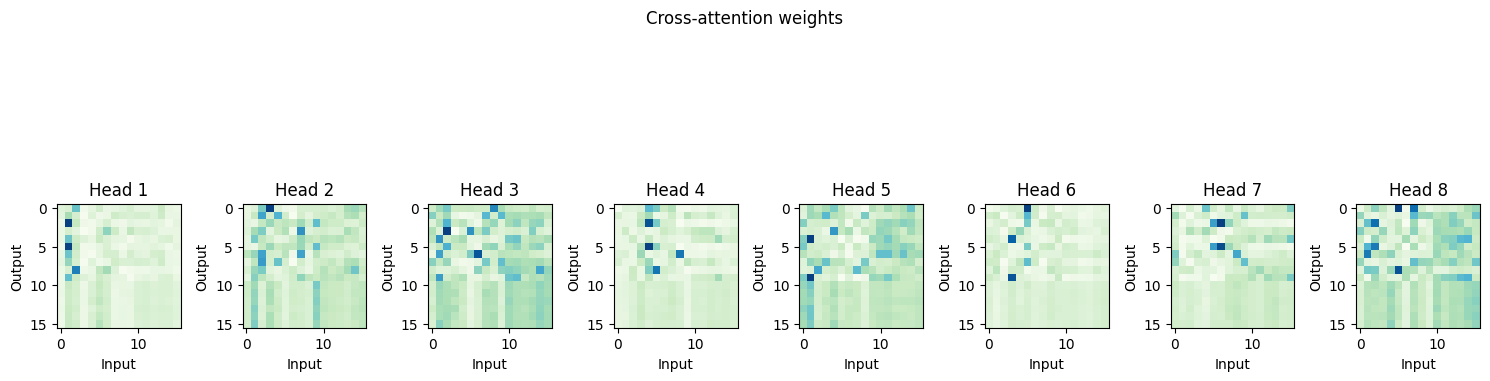

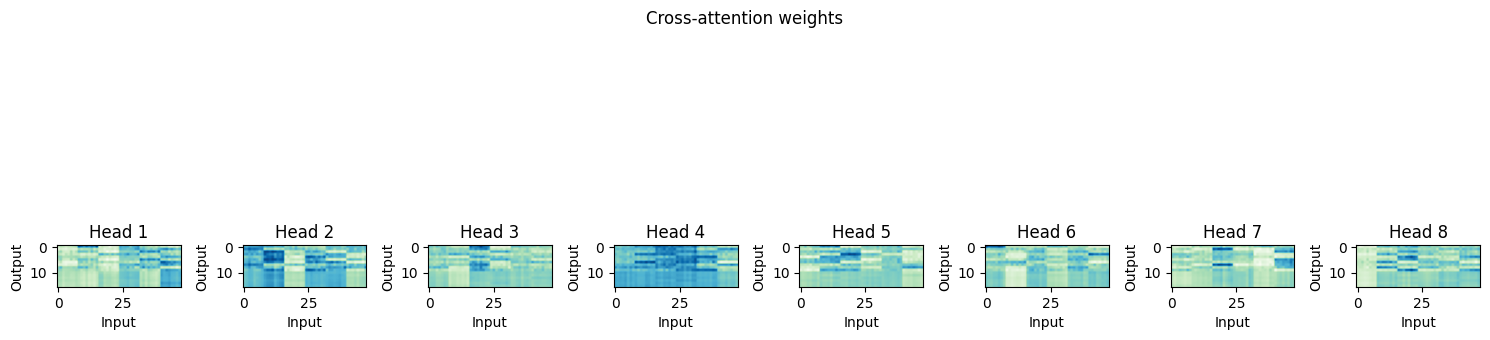

In [35]:
plot_attention(self_attn_ws)
plot_attention(cross_attn_ws_seq, kind="cross")
plot_attention(cross_attn_ws_tokens)

#### Action Generator

In [390]:
generator = ActionGenerator().cuda()
print(generator)
summary(generator)

ActionGenerator(
  (proj): Sequential(
    (0): Linear(in_features=512, out_features=52, bias=True)
    (1): Dropout(p=0.15, inplace=False)
  )
  (_softmax): LogSoftmax(dim=-1)
)


Layer (type:depth-idx)                   Param #
ActionGenerator                          --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       26,676
│    └─Dropout: 2-2                      --
├─LogSoftmax: 1-2                        --
Total params: 26,676
Trainable params: 26,676
Non-trainable params: 0

In [392]:
preds = generator(dec_out)
preds.shape

torch.Size([4, 16, 52])

In [393]:
predicted_next_tok = preds[:, -1, :].argmax(dim=-1)
predicted_next_tok.shape, predicted_next_tok

(torch.Size([4]), tensor([5, 5, 5, 5], device='cuda:0'))

### RT-1 Decoder

In [41]:
decoder = RT1Decoder(num_decoder_layers=1).cuda()
print(decoder)
decoder.eval()
summary(model=decoder)

RT1Decoder(
  (target_embedding): Embedding(52, 512, padding_idx=0)
  (transformer): TransformerDecoder(
    (token_emb): Linear(in_features=512, out_features=512, bias=False)
    (position_emb): Linear(in_features=16, out_features=512, bias=False)
    (layers): ModuleList(
      (0): TransformerDecoderLayer(
        (self_attn): MultiHeadSelfAttention(
          (attention_heads): ModuleList(
            (0-7): 8 x SelfAttentionHead(
              (dropout): Dropout(p=0.2, inplace=False)
              (_softmax): Softmax(dim=-1)
              (w_q): Linear(in_features=512, out_features=512, bias=False)
              (w_k): Linear(in_features=512, out_features=512, bias=False)
              (w_v): Linear(in_features=512, out_features=512, bias=False)
            )
          )
          (output_layer): Sequential(
            (0): Linear(in_features=4096, out_features=512, bias=False)
            (1): Dropout(p=0.2, inplace=False)
          )
        )
        (cross_attn): MultiHeadSel

Layer (type:depth-idx)                                  Param #
RT1Decoder                                              --
├─Embedding: 1-1                                        26,624
├─TransformerDecoder: 1-2                               --
│    └─Linear: 2-1                                      262,144
│    └─Linear: 2-2                                      8,192
│    └─ModuleList: 2-3                                  --
│    │    └─TransformerDecoderLayer: 3-1                18,880,000
├─LayerNormalization: 1-3                               --
│    └─LayerNorm: 2-4                                   1,024
├─ActionGenerator: 1-4                                  --
│    └─Sequential: 2-5                                  --
│    │    └─Linear: 3-2                                 26,676
│    │    └─Dropout: 3-3                                --
│    └─LogSoftmax: 2-6                                  --
Total params: 19,204,660
Trainable params: 19,204,660
Non-trainable params: 0

In [43]:
%time

preds, self_attn_ws, cross_attn_ws_seq, cross_attn_ws_tokens = decoder(
    inp=sample["motor_cmd"]["decoder_inp_ids"].cuda(), 
    encoder_outs=(text_enc_h_state, learned_tokens), 
    src_mask=(sample["source_mask"].cuda(), sample["source_mask_tokens"].cuda()), 
    target_mask=sample["target_mask"].cuda(), 
    debug=False
)

preds.shape, self_attn_ws.shape, cross_attn_ws_seq.shape, cross_attn_ws_tokens.shape

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.25 µs


(torch.Size([8, 16, 52]),
 torch.Size([8, 8, 16, 16]),
 torch.Size([8, 8, 16, 16]),
 torch.Size([8, 8, 16, 48]))

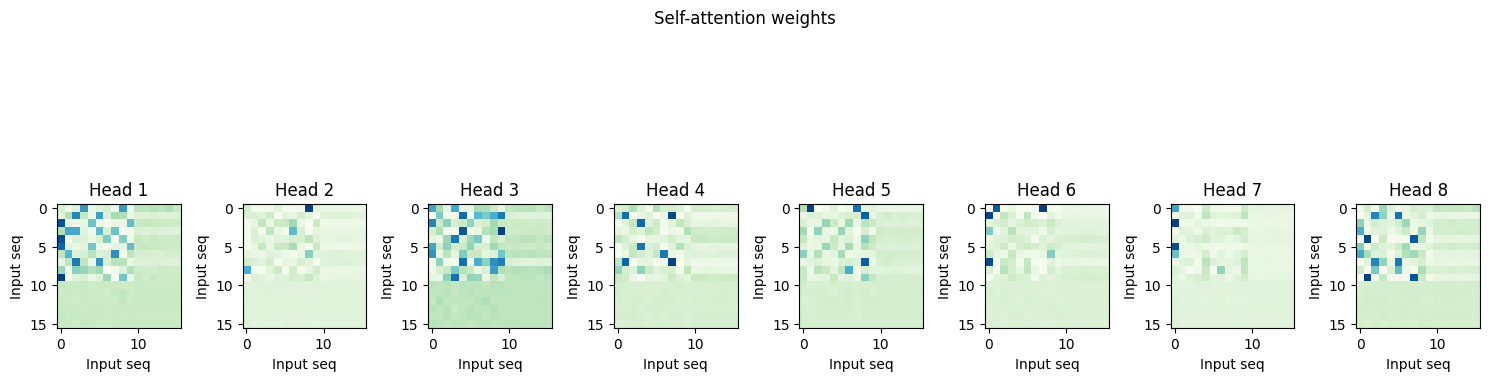

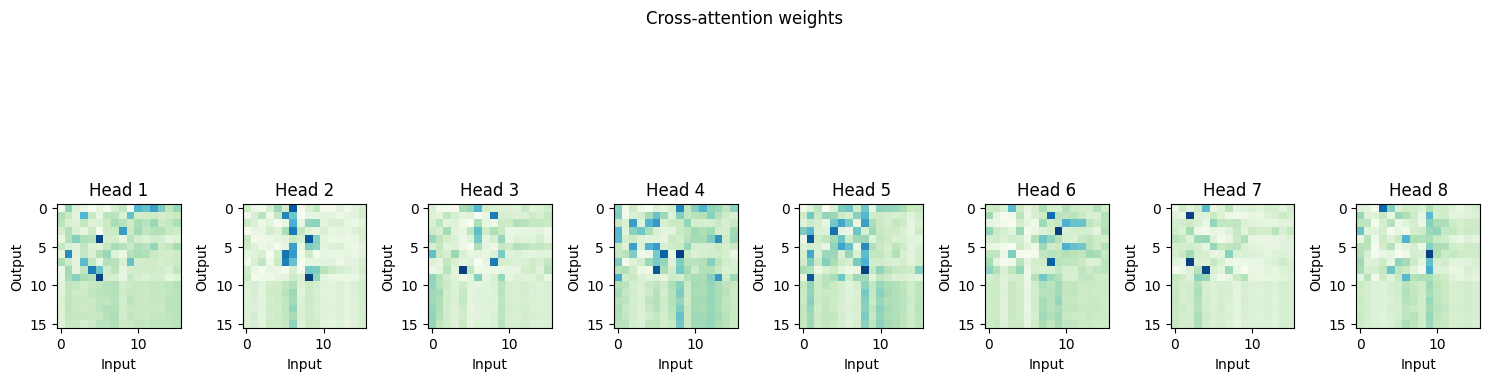

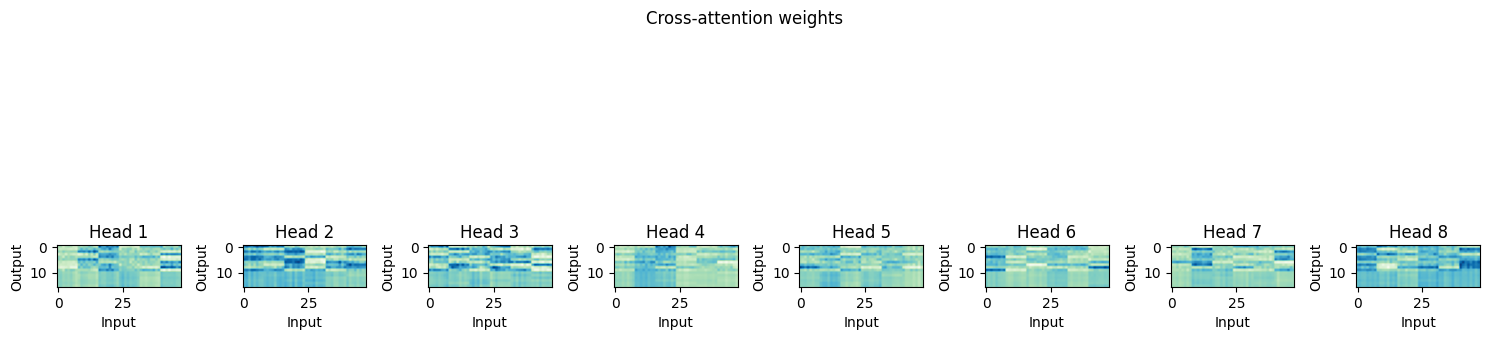

In [44]:
plot_attention(self_attn_ws)
plot_attention(cross_attn_ws_seq, kind="cross")
plot_attention(cross_attn_ws_tokens)

In [81]:
attn_plot = plot_attention(self_attn_ws, show=False)
attn_plot.shape

(1500, 4500, 3)

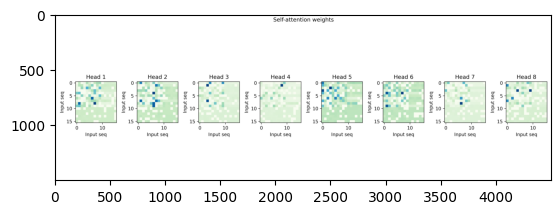

In [82]:
pyplot.imshow(attn_plot)

### RT-1 

In [102]:
class RT1(pl.LightningModule):
    def __init__(
        self,
        cnn_bacnbone:str="efficientnet_b3",
        num_res_blocks:int=config.NUM_RES_BLOCKS,
        num_decoder_layers:int=config.N_DECODER_LAYERS
    ):
        super().__init__()
        self.encoder = RT1Encoder(cnn_bacnbone=cnn_bacnbone, num_res_blocks=num_res_blocks)
        self.decoder = RT1Decoder(num_decoder_layers=num_decoder_layers)
        self.loss_fn = nn.CrossEntropyLoss(
            ignore_index=config.TGT_PAD_TOK_ID, 
            label_smoothing=config.LABEL_SMOOTHING
        )
        
    def forward(
        self, 
        input_ids:torch.tensor, 
        attn_mask:torch.tensor, 
        token_type_ids:torch.tensor, 
        imgs:torch.tensor,
        decoder_inp:torch.tensor,
        src_mask:Tuple[torch.Tensor, torch.Tensor], 
        target_mask:torch.tensor
    ):
        
        text_enc_last_h, learned_tokens = self.encoder(
            input_ids=input_ids, 
            attn_mask=attn_mask, 
            token_type_ids=token_type_ids, 
            imgs=imgs
        )
        
        return self.decoder(
            inp=decoder_inp, 
            encoder_outs=(text_enc_last_h, learned_tokens), 
            src_mask=src_mask, 
            target_mask=target_mask 
        )
    
    def configure_optimizers(self):
        
        opt = getattr(torch.optim, config.OPTIMIZER)(
            params=[p for p in self.parameters() if p.requires_grad], 
            lr=config.LR,
            weight_decay=config.WEIGHT_DECAY
        )
        
        scheduler = getattr(torch.optim.lr_scheduler, config.LR_SCHEDULER["type"])(
            opt, 
            **config.LR_SCHEDULER["params"]
        )
        
        return {"optimizer": opt, "lr_scheduler": scheduler, "monitor": "val_loss"}
    
    def _step(self, batch):
        
        input_ids=batch["action_desc"]["ids"]
        attn_mask=batch["action_desc"]["mask"]
        token_type_ids=batch["action_desc"]["token_type_ids"]
        imgs=batch["in_state"]
        decoder_inp=batch["motor_cmd"]["decoder_inp_ids"] 
        src_mask=batch["source_mask"] 
        src_mask_tokens=batch["source_mask_tokens"] 
        target_mask=batch["target_mask"] 
        
        # forward pass
        return self(
            input_ids=input_ids, 
            attn_mask=attn_mask, 
            token_type_ids=token_type_ids, 
            imgs=imgs,
            decoder_inp=decoder_inp, 
            src_mask=(src_mask, src_mask_tokens), 
            target_mask=target_mask 
        )
    
    def training_step(self, batch, batch_idx):
        preds, self_attn_ws, cross_attn_ws_seq, cross_attn_ws_tokens = self._step(batch)
        
        # compute loss
        labels = batch["motor_cmd"]["labels"]
        train_loss = self.loss_fn(preds.view(-1, preds.shape[2]), labels.view(-1))
        
        # return loss
        metrics = {"loss": train_loss, "train_loss": train_loss}
        self.log("train_loss", train_loss, prog_bar=True, logger=True, on_step=True, on_epoch=True)
        
        return metrics
    
    def validation_step(self, batch, batch_idx):
        
        preds, self_attn_ws, cross_attn_ws_seq, cross_attn_ws_tokens = self._step(batch)
        # compute loss
        labels = batch["motor_cmd"]["labels"]
        val_loss = self.loss_fn(preds.view(-1, preds.shape[2]), labels.view(-1))
        
        # # plot attention weights
        # if batch_idx % 50 == 0:
        #     self.logger.experiment.add_image(
        #         "self-attention", 
        #         plot_attention(self_attn_ws, show=False), 
        #         self.global_step
        #     )
        #     self.logger.experiment.add_image(
        #         "Seq Cross-attention", 
        #         plot_attention(cross_attn_ws_seq, show=False), 
        #         self.global_step
        #     )
        #     self.logger.experiment.add_image(
        #         "Seq/Tokens Corss-attention", 
        #         plot_attention(cross_attn_ws_tokens, show=False), 
        #         self.global_step
        #     )
            
        # return loss
        metrics = {"val_loss": val_loss}
        self.log("val_loss", val_loss, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        
        return metrics
    
    def test_step(self, batch, batch_idx):
        pass
    

## Training

In [103]:
_ = seed_everything(config.SEED)

[rank: 0] Seed set to 1234


In [104]:
rt1 = RT1(cnn_bacnbone="resnet18").cuda()
# print(rt1)

summary(model=rt1)

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet18.a1_in1k)
INFO:timm.models._hub:[timm/resnet18.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


Layer (type:depth-idx)                                            Param #
RT1                                                               --
├─RT1Encoder: 1-1                                                 --
│    └─TextEncoder: 2-1                                           --
│    │    └─BertModel: 3-1                                        (28,763,648)
│    │    └─Dropout: 3-2                                          --
│    └─FiLMEncoder: 2-2                                           --
│    │    └─ImageFeatureExtractor: 3-3                            11,439,168
│    │    └─ModuleList: 3-4                                       5,283,840
│    └─TokenLearnerModuleV11: 2-3                                 --
│    │    └─LayerNormalization: 3-5                               1,024
│    │    └─FeedFowardLayer: 3-6                                  66,696
├─RT1Decoder: 1-2                                                 --
│    └─Embedding: 2-4                                             

In [105]:
input_ids=sample["action_desc"]["ids"].cuda()
attn_mask=sample["action_desc"]["mask"].cuda()
token_type_ids=sample["action_desc"]["token_type_ids"].cuda()
imgs=sample["in_state"].cuda()
decoder_inp=sample["motor_cmd"]["decoder_inp_ids"].cuda()
src_mask=(sample["source_mask"].cuda(), sample["source_mask_tokens"].cuda())
target_mask=sample["target_mask"] .cuda()

In [106]:
 preds, self_attn_ws, cross_attn_ws_seq, cross_attn_ws_tokens = rt1(
    input_ids=input_ids, 
    attn_mask=attn_mask, 
    token_type_ids=token_type_ids, 
    imgs=imgs,
    decoder_inp=decoder_inp, 
    src_mask=src_mask, 
    target_mask=target_mask 
)
    
preds.shape, self_attn_ws.shape, cross_attn_ws_seq.shape, cross_attn_ws_tokens.shape

(torch.Size([8, 16, 52]),
 torch.Size([8, 8, 16, 16]),
 torch.Size([8, 8, 16, 16]),
 torch.Size([8, 8, 16, 48]))

#### Progress bar workaround
> from: https://github.com/Lightning-AI/lightning/issues/15283

In [107]:
class MyProgressBar(TQDMProgressBar):
    def init_validation_tqdm(self):
        bar = super().init_validation_tqdm()
        if not sys.stdout.isatty():
            bar.disable = True
        return bar

    def init_predict_tqdm(self):
        bar = super().init_predict_tqdm()
        if not sys.stdout.isatty():
            bar.disable = True
        return bar

    def init_test_tqdm(self):
        bar = super().init_test_tqdm()
        if not sys.stdout.isatty():
            bar.disable = True
        return bar

#### Loggers

In [108]:
tb_logger = TensorBoardLogger(save_dir="tb_logs", name="RT1")

In [ ]:
# create your own theme!
# progress_bar = RichProgressBar(
#     theme=RichProgressBarTheme(
#         description="green_yellow",
#         progress_bar="green1",
#         progress_bar_finished="green1",
#         progress_bar_pulse="#6206E0",
#         batch_progress="green_yellow",
#         time="grey82",
#         processing_speed="grey82",
#         metrics="grey82",
#         metrics_text_delimiter="\n",
#         metrics_format=".3e",
#     ),
#     leave=False
# )


trainer = Trainer(
    enable_progress_bar=True,
    # deterministic=True, 
    min_epochs=2, 
    max_epochs=config.EPOCHS, 
    gradient_clip_val=config.GRAD_CLIP_VAL, 
    # fast_dev_run=True,
    callbacks=[MyProgressBar()],
    logger=tb_logger
)

dm = BEDataModule()
trainer.fit(model=rt1, datamodule=dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:Training on 3613 samples.
INFO:root:Validating on 895 samples.
INFO:root:Testing on 250 samples.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | encoder | RT1Encoder       | 45.6 M
1 | decoder | RT1Decoder       | 19.2 M
2 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
24.8 M    Trainable params
39.9 M    Non-trainable params
64.8 M    Total params
259.036   Total estimated model params size (MB)


Total # examples: 4758
Sanity Checking: |          | 0/? [00:00<?, ?it/s]

## Tensorboard

In [95]:
%tensorboard --logdir tb_logs

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

## Tests

In [ ]:
# input_ids=sample["action_desc"]["ids"].cuda()
# attn_mask=sample["action_desc"]["mask"].cuda()
# token_type_ids=sample["action_desc"]["token_type_ids"].cuda()
# imgs=sample["in_state"].cuda()
# decoder_inp=sample["motor_cmd"]["decoder_inp_ids"].cuda()
# src_mask=sample["source_mask"].cuda()
# target_mask=sample["target_mask"] .cuda()

In [105]:
rt1.eval()
preds, self_attn_ws, cross_attn_ws = rt1(
    input_ids=input_ids, 
    attn_mask=attn_mask, 
    token_type_ids=token_type_ids, 
    imgs=imgs,
    decoder_inp=decoder_inp, 
    src_mask=src_mask, 
    target_mask=target_mask 
)

#### Visualize learned attention weights

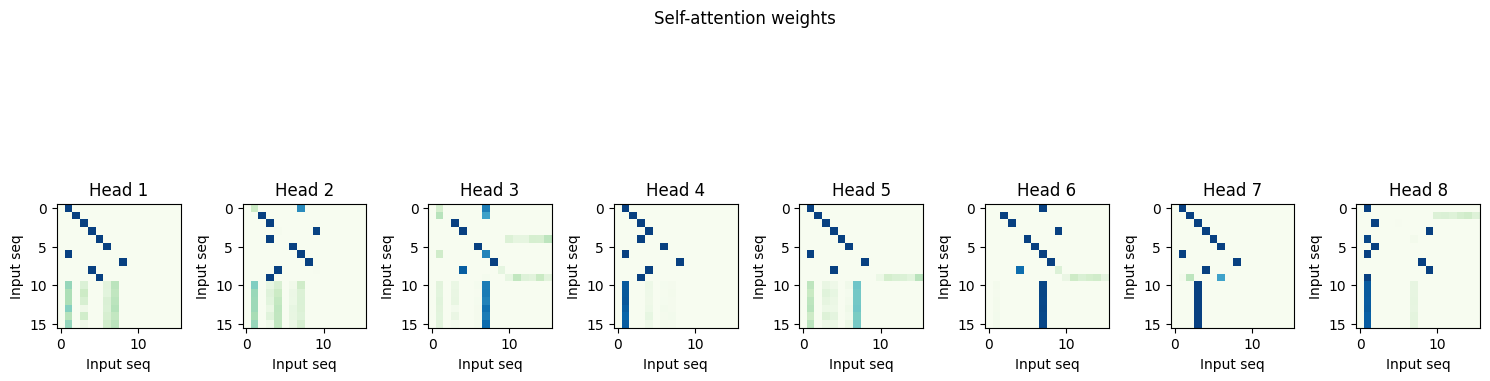

In [106]:
plot_attention(self_attn_ws)

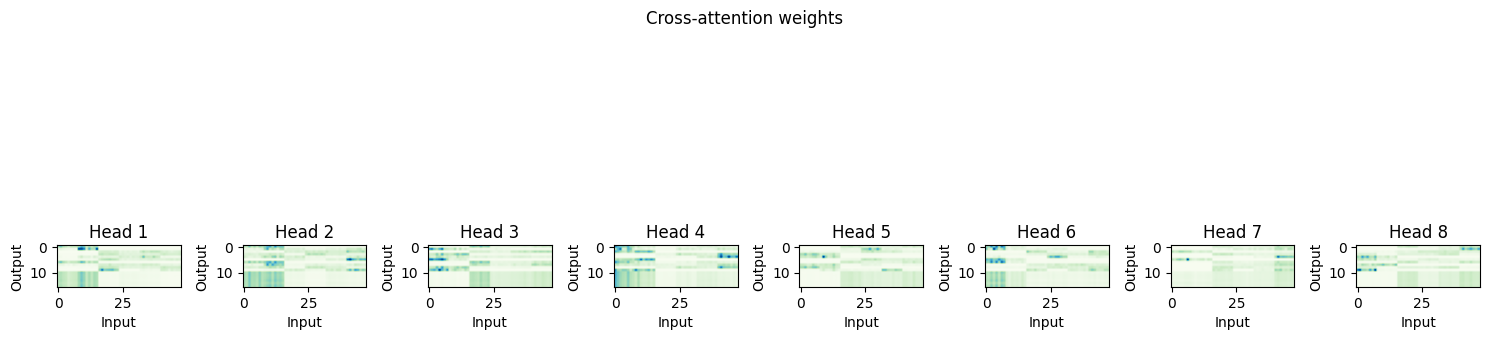

In [107]:
plot_attention(cross_attn_ws)